In [ ]:
# lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['subject_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('TrainingData/', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    # load all test
    testX, testy = load_dataset_group('TestData/', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores):
        print(scores)
        m, s = mean(scores), std(scores)
        print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
run_experiment()

In [172]:
import pandas
from datetime import datetime
import random
from keras import utils
from numpy import dstack

samples = [[1,1], [1,2], [1,3], [1,4], [1,5], [1,6], [1,7], [1,8], [2,1], [2,2], [2,3], [2,4], [2,5], [3,1], [3,2], [3,3], [4,1], [4,2], [5,1], [5,2], [5,3], [6,1], [6,2], [6,3], [7,1], [7,2], [7,3], [7,4], [8,1]]
random.seed
random.shuffle(samples)

trainX = pandas.DataFrame()
trainY = pandas.DataFrame() 
testX = pandas.DataFrame() 
testY = pandas.DataFrame() 
split = int(len(samples)*.5)

for i in range(0, split):
    time = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__x_time.csv", header=None)
    dataX = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__x.csv", header=None)
    dataX.columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']
    dataX['time'] = time
    dataX.set_index('time', inplace = True)
    
    time = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__y_time.csv", header=None)
    dataY = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__y.csv", header=None)
    dataY.columns = ['action']
    dataY['time'] = time
    dataY.set_index('time', inplace = True)
    
    #Interpolate the X labels
    timesY = pandas.DataFrame(index=dataY.index)
    dataX = dataX.join(timesY, how='outer')
    dataX = dataX.interpolate(method='linear')
    dataX = dataX[dataX.index.isin(timesY.index)]
    
    trainX = trainX.append(dataX)
    trainY = trainY.append(dataY)    
    
for i in range(split, len(samples)):
    time = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__x_time.csv", header=None)
    dataX = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__x.csv", header=None)
    dataX.columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']
    dataX['time'] = time
    dataX.set_index('time', inplace = True)
    
    time = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__y_time.csv", header=None)
    dataY = read_csv("./TrainingData/subject_00" + str(samples[i][0]) + "_0" + str(samples[i][1]) + "__y.csv", header=None)
    dataY.columns = ['action']
    dataY['time'] = time
    dataY.set_index('time', inplace = True)
    
    #Interpolate the X labels
    timesY = pandas.DataFrame(index=dataY.index)
    dataX = dataX.join(timesY, how='outer')
    dataX = dataX.interpolate(method='linear')
    dataX = dataX[dataX.index.isin(timesY.index)]
    
    testX = testX.append(dataX)
    testY = testY.append(dataY)
    
print(trainX)
print(trainY)
print(testX)
print(testY)
trainY = utils.to_categorical(trainY)
testY = utils.to_categorical(testY)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

               aX        aY        aZ        gX        gY        gZ
time                                                               
0.02    -1.016447  9.568449  1.678837 -0.001011  0.040077 -0.013063
0.12    -0.843081  9.627510  1.705337  0.013878  0.012770 -0.009999
0.22    -0.764475  9.589222  1.611973  0.000617  0.020903 -0.019452
0.32    -0.715501  9.598018  1.673018  0.013868 -0.052573 -0.037165
0.42    -0.942921  9.553711  1.843862  0.122363 -0.120394 -0.014721
...           ...       ...       ...       ...       ...       ...
1203.02  2.084625  8.902639 -3.529154  0.001576 -0.000445  0.001405
1203.12  2.079276  8.909741 -3.528327 -0.000584 -0.003949 -0.002194
1203.22  2.068492  8.901280 -3.509776 -0.003307 -0.000556 -0.000556
1203.32  2.085272  8.901138 -3.505000  0.001273  0.000763  0.001029
1203.42  2.099589  8.904276 -3.527294  0.000118 -0.001470  0.000928

[151664 rows x 6 columns]
         action
time           
0.02          0
0.12          0
0.22          0
0.32     

In [180]:
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dropout, Flatten, Dense, LSTM

# define model
verbose, epochs, batch_size = 0, 25, 64
n_timesteps = trainX.shape[0]
n_features = trainX.shape[1]
n_outputs = trainY.shape[1]
# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32
finalTrainX = trainX.values.reshape((trainX.shape[0], 1, n_features))
finalTestX = testX.values.reshape((testX.shape[0], 1, n_features))
# define model
model = Sequential()
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(finalTrainX, trainY, validation_data=(finalTestX, testY), epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/25
2370/2370 [==============================] - 6s 2ms/step - loss: 0.7572 - accuracy: 0.7595 - val_loss: 0.7178 - val_accuracy: 0.7434
Epoch 2/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6592 - accuracy: 0.7813 - val_loss: 0.6972 - val_accuracy: 0.7491
Epoch 3/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6362 - accuracy: 0.7878 - val_loss: 0.6979 - val_accuracy: 0.7488
Epoch 4/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6285 - accuracy: 0.7898 - val_loss: 0.6755 - val_accuracy: 0.7547
Epoch 5/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6169 - accuracy: 0.7931 - val_loss: 0.6691 - val_accuracy: 0.7553
Epoch 6/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6161 - accuracy: 0.7914 - val_loss: 0.6713 - val_accuracy: 0.7532
Epoch 7/25
2370/2370 [==============================] - 5s 2ms/step - loss: 0.6130 - accuracy: 0.7922 - val_loss: 0.6695 - val_accuracy:

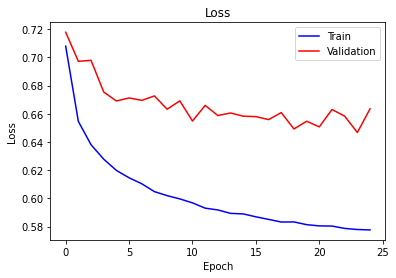

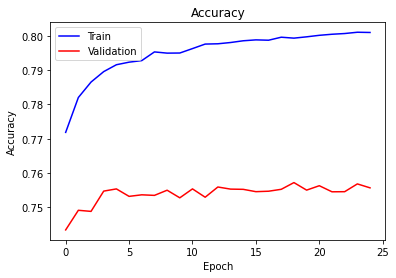

In [185]:
import matplotlib.pyplot as plt

def plot_history(history):
    # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
plot_history(history)

In [268]:
import pandas
from datetime import datetime
import random
from keras import utils
import numpy

samples = [["09",1], ["10",1], ["11",1], ["12",1]]

for i in range(0, 4):
    predictX = pandas.DataFrame()
    predictY = pandas.DataFrame()
    time = read_csv("./TestData/subject_0" + samples[i][0] + "_0" + str(samples[i][1]) + "__x_time.csv", header=None)
    pdataX = read_csv("./TestData/subject_0" + samples[i][0] + "_0" + str(samples[i][1]) + "__x.csv", header=None)
    pdataX.columns = ['aX', 'aY', 'aZ', 'gX', 'gY', 'gZ']
    pdataX['time'] = time
    pdataX.set_index('time', inplace = True)
    
    time = read_csv("./TestData/subject_0" + samples[i][0] + "_0" + str(samples[i][1]) + "__y_time.csv", header=None, index_col=None)
    time['time'] = time
    time.set_index('time', inplace = True)
    
    #Interpolate the X labels
    #Interpolate the X labels
    timesY = pandas.DataFrame(index=time.index)
    pdataX = pdataX.join(timesY, how='outer')
    pdataX = pdataX.interpolate(method='linear')
    pdataX = pdataX[pdataX.index.isin(timesY.index)]
    
    n_features = pdataX.shape[1]
    predictX = pdataX.values.reshape((pdataX.shape[0], 1, n_features))
    predictY = predictY.append(time)
    prediction = numpy.argmax(model.predict(predictX), axis=-1)
    df = pandas.DataFrame({'action': prediction})
    df.index = predictY.index
    predictY = predictY.join(df)
    predictY = predictY.drop(predictY.columns[0], axis=1)
    with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(predictY)

        action
time          
0.02         0
0.12         0
0.22         0
0.32         0
0.42         0
0.52         0
0.62         0
0.72         0
0.82         0
0.92         0
1.02         0
1.12         0
1.22         0
1.32         0
1.42         0
1.52         0
1.62         0
1.72         0
1.82         0
1.92         0
2.02         0
2.12         0
2.22         0
2.32         0
2.42         0
2.52         0
2.62         0
2.72         0
2.82         0
2.92         0
3.02         0
3.12         0
3.22         0
3.32         0
3.42         0
3.52         0
3.62         0
3.72         0
3.82         0
3.92         0
4.02         0
4.12         0
4.22         0
4.32         0
4.42         0
4.52         0
4.62         0
4.72         0
4.82         0
4.92         0
5.02         0
5.12         0
5.22         0
5.32         0
5.42         0
5.52         0
5.62         0
5.72         0
5.82         0
5.92         0
6.02         0
6.12         0
6.22         0
6.32         0
6.42      

         action
time           
0.02          0
0.12          0
0.22          0
0.32          0
0.42          0
0.52          0
0.62          0
0.72          0
0.82          0
0.92          0
1.02          0
1.12          0
1.22          0
1.32          0
1.42          0
1.52          0
1.62          0
1.72          0
1.82          0
1.92          0
2.02          0
2.12          0
2.22          0
2.32          0
2.42          0
2.52          0
2.62          0
2.72          0
2.82          0
2.92          0
3.02          0
3.12          0
3.22          0
3.32          0
3.42          0
3.52          0
3.62          0
3.72          0
3.82          0
3.92          0
4.02          0
4.12          0
4.22          0
4.32          0
4.42          0
4.52          0
4.62          0
4.72          0
4.82          0
4.92          0
5.02          0
5.12          0
5.22          0
5.32          0
5.42          0
5.52          0
5.62          0
5.72          0
5.82          0
5.92          0
6.02    

         action
time           
0.02          0
0.12          0
0.22          0
0.32          0
0.42          0
0.52          0
0.62          0
0.72          0
0.82          0
0.92          0
1.02          0
1.12          0
1.22          0
1.32          0
1.42          0
1.52          0
1.62          0
1.72          0
1.82          0
1.92          0
2.02          0
2.12          0
2.22          0
2.32          0
2.42          0
2.52          0
2.62          0
2.72          0
2.82          0
2.92          0
3.02          0
3.12          0
3.22          0
3.32          0
3.42          0
3.52          0
3.62          0
3.72          0
3.82          0
3.92          0
4.02          0
4.12          0
4.22          0
4.32          0
4.42          0
4.52          0
4.62          0
4.72          0
4.82          0
4.92          0
5.02          0
5.12          0
5.22          0
5.32          0
5.42          0
5.52          0
5.62          0
5.72          0
5.82          0
5.92          0
6.02    

         action
time           
0.02          0
0.12          0
0.22          0
0.32          0
0.42          0
0.52          0
0.62          0
0.72          0
0.82          0
0.92          0
1.02          0
1.12          0
1.22          0
1.32          0
1.42          0
1.52          0
1.62          0
1.72          0
1.82          0
1.92          0
2.02          0
2.12          0
2.22          0
2.32          0
2.42          0
2.52          1
2.62          1
2.72          2
2.82          0
2.92          0
3.02          0
3.12          0
3.22          0
3.32          0
3.42          0
3.52          0
3.62          0
3.72          0
3.82          0
3.92          0
4.02          0
4.12          2
4.22          2
4.32          0
4.42          0
4.52          0
4.62          0
4.72          0
4.82          0
4.92          0
5.02          0
5.12          0
5.22          0
5.32          0
5.42          0
5.52          0
5.62          0
5.72          0
5.82          0
5.92          0
6.02    